# Druhý projekt z předmětu MSP 2023/2024

__Autor:__

David Chocholatý, xchoch09

---

Projekt se skládá ze dvou úloh:
- využití bayesovských odhadů a simulace rozdělení z naměřených dat,
- regresní analýza.

In [1]:
# Import potřebných knihoven a funkcí pro první i druhou úlohu.
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.formula.api as smf
import numpy as np
import seaborn as sns

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.stats._adnorm import normal_ad
from statsmodels.stats.stattools import durbin_watson

## Úloha 1 - Bayesovské odhady

### a) Konjugované apriorní a aposteriorní rozdělení, prediktivní rozdělení

Zadání:

<em>Předpokládáme, že počet připojení na internetovou síť za 1 ms je popsaný náhodnou veličinou
s Poissonovým rozdělením s parametrem 𝜆, t.j. 𝑋~𝑃𝑜(𝜆).
O parametru 𝜆 máme následující expertní odhad: každých 5 ms by mělo nastat 10 připojení.
Pozorovali jsme připojení po dobu 100 ms. Pozorovaní o počtu připojení za každou 1 ms jsou
uvedené v souboru measurements.csv ve sĺoupci „úloha_1 a)“.</em>

<em>Vašim zadáním je z této expertní informace urči konjugované apriorní rozdělení k parametru
Poissonova rozdělení a na základě pozorovaní určit aposteriorní rozdělení. Dále určete
apriorní a aposteriorní prediktivní rozdělení pozorovaní. </em>

---

In [2]:
# Načtení vstupních dat ze souboru xlsx z listu s názvem "Úloha 1".
df_1 = pd.read_excel(open('Projekt-2_Data.xlsx', 'rb'), sheet_name='Úloha 1')
df_1

,uloha_1 a),uloha_1 b)_prior,skupina,uloha_1 b)_pozorování
0,2.0,3.634785,0,3.626656
1,2.0,2.868113,0,3.008269
2,1.0,2.149160,0,2.989829
3,3.0,4.263065,0,2.371630
4,0.0,2.594745,0,4.009366
...,...,...,...,...
99995,NaN,1.725637,9999,NaN
99996,NaN,4.048414,9999,NaN
99997,NaN,3.000662,9999,NaN
99998,NaN,3.058451,9999,NaN


In [3]:
# Načtení hodnot pozorování pro úlohu "a".
OBSERVATIONS_COUNT = 100

observations = df_1['uloha_1 a)'][:OBSERVATIONS_COUNT]
observations = observations.astype('int64')
observations

0     2
1     2
2     1
3     3
4     0
     ..
95    3
96    0
97    3
98    1
99    1
Name: uloha_1 a), Length: 100, dtype: int64

Zadání:

<em>1) Do jednoho obrázku vykreslíte apriorní a aposteriorní hustotou parametru Poissonova
rozdělení 𝜆.</em>

---

Konjugovaná apriorní pravděpodobnost bude určena na základě expertní informace. Dle [1] jsou parametry alfa a beta interpretovány jako celkový počet výskytů α v β intervalech. Aposteriorní alfa a beta budou vypočítány dle vztahů z [1], tedy

$$\alpha + \sum_{i=1}^{n}x^i, \beta + n.$$

[1] https://en.wikipedia.org/wiki/Conjugate_prior

Apriorní:
-----------
alfa: 10
beta: 5

Aposteriorní:
-----------
alfa: 176
beta: 105


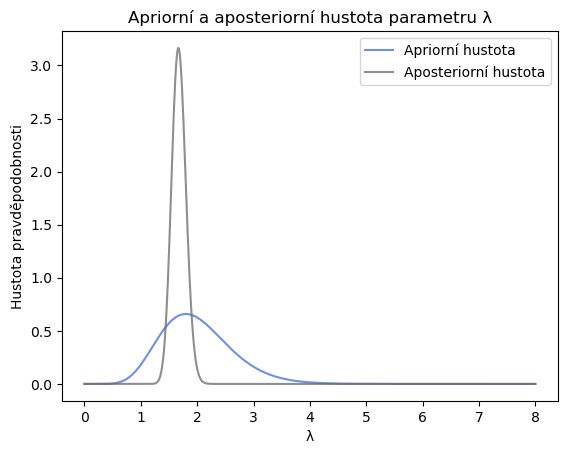

In [4]:

# Apriorní alfa a beta (expertní informace).
alpha_prior = 10
beta_prior = 5

# Aposteriorní alfa a beta.
alpha_posterior = alpha_prior + sum(observations)
beta_posterior = beta_prior + len(observations)

print('Apriorní:')
print('-----------')
print('alfa: ' + str(alpha_prior))
print('beta: ' + str(beta_prior))
print()
print('Aposteriorní:')
print('-----------')
print('alfa: ' + str(alpha_posterior))
print('beta: ' + str(beta_posterior))

# Nastavení hodnot osy x (𝜆), pro které se budou vykreslovat body v y-ové ose (Hustota pravděpodobnosti).
x = np.linspace(0, 8, 1000)

# Výpočet funkce hustoty pravděpodobnosti s využitím gamma rozdělení pomocí příslušné funkce ze stats.gamma.
# Při výpočtu s využitím parametrů alfa a beta se parametr beta zadává v převrácené hodnotě, tedy 1/beta.
pdf_prior = stats.gamma.pdf(x, alpha_prior, scale=1/beta_prior)
pdf_posterior = stats.gamma.pdf(x, alpha_posterior, scale=1/beta_posterior)

# Vyobrazení grafu hustoty.
fig, ax = plt.subplots(1, 1)
plt.title('Apriorní a aposteriorní hustota parametru λ')
ax.plot(x, pdf_prior, color='royalblue', label='Apriorní hustota', alpha=0.75)
ax.plot(x, pdf_posterior, color='dimgray', label='Aposteriorní hustota', alpha=0.75)
ax.legend(loc='best')
plt.xlabel('λ')
plt.ylabel('Hustota pravděpodobnosti')
plt.show()

Zadání:

<em>2) Do jednoho obrázku vykreslíte apriorní a aposteriorní prediktivní hustotou pozorovaní
𝑥 za jeden časový interval.</em>

---

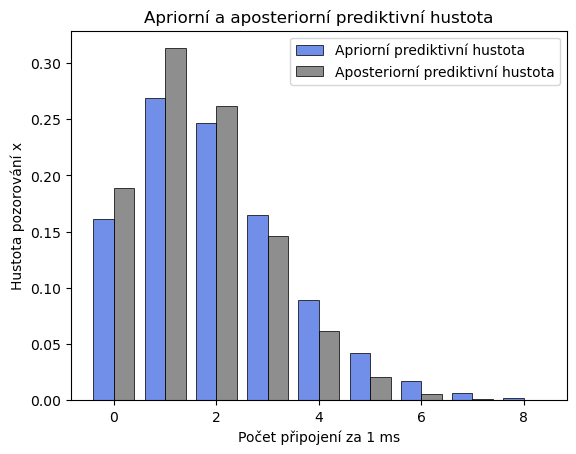

In [5]:
# Nastavení hodnot osy x (Počet připojení za 1 ms), pro které se budou vykreslovat
# hodnoty v y-ové ose (Hustota pozorování x).
x = np.arange(0, 9)

# Výpočet pravděpodobnostní funkce s využitím Negativního binomického rozdělení pomocí příslušné funkce 
# ze stats.nbinom. Při výpočtu s parametry alfa a beta se parametr beta zadává ve tvaru: beta / (1 + beta),
# více viz: https://en.wikipedia.org/wiki/Conjugate_prior.
pmf_prior = stats.nbinom.pmf(x, alpha_prior, beta_prior/(1 + beta_prior))
pmf_posterior = stats.nbinom.pmf(x, alpha_posterior, beta_posterior/(1 + beta_posterior))

# Vyobrazení grafu prediktivní hustoty.
fig, ax = plt.subplots(1, 1)
plt.title('Apriorní a aposteriorní prediktivní hustota')
plt.bar(x - 0.2, pmf_prior, width=0.4, color='royalblue', edgecolor = 'black', linewidth=0.7,
        label='Apriorní prediktivní hustota', alpha=0.75)
plt.bar(x + 0.2, pmf_posterior, width=0.4, color='dimgray', edgecolor = 'black', linewidth=0.7,
        label='Aposteriorní prediktivní hustota', alpha=0.75)
ax.legend(loc='best')
plt.xlabel('Počet připojení za 1 ms')
plt.ylabel('Hustota pozorování x')
plt.show()

Zadání:

<em>3) Sestrojte 95% interval spolehlivosti pro parametr 𝜆 z apriorního a aposteriorního
rozdělení a porovnejte je.</em>

---

In [6]:
# Interval spolehlivosti pro apriorní rozdělení.
low_prior = stats.gamma.ppf(0.025, alpha_prior, scale=1/beta_prior)
high_prior = stats.gamma.ppf(0.975, alpha_prior, scale=1/beta_prior)

# Interval spolehlivosti pro aposteriorní rozdělení.
low_posterior = stats.gamma.ppf(0.025, alpha_posterior, scale=1/beta_posterior)
high_posterior = stats.gamma.ppf(0.975, alpha_posterior, scale=1/beta_posterior)

print("Apriorní:")
print(low_prior, high_prior)
print("Aposteriorní:")
print(low_posterior, high_posterior)

Apriorní:
0.9590777392264868 3.416960690283833
Aposteriorní:
1.4376938284869922 1.9327207471868797


Jelikož interval aposteriorního odhadu je užší, vyplývá, že oproti apriornímu odhadu je aposteriorní odhad přesnější.

Zadání

<em>4) Vyberte si dva aposteriorní bodové odhady parametru 𝜆, porovnejte je a okomentujte
jejich výběr.</em>

---

Pro porovnání byly vybrány bodové odhady s využitím střední hodnoty a mediánu.

In [7]:
mean = alpha_posterior / beta_posterior
median = stats.gamma.ppf(0.5, a=alpha_posterior, scale=1/beta_posterior)

print("Střední hodnota:")
print(mean)
print()
print("Medián:")
print(median)

Střední hodnota:
1.6761904761904762

Medián:
1.6730169441241727


Na základě skutečnosti, že hodnoty obou odhadů jsou velmi podobné, vyplývá, že rozložení dat je symetrické.

Zadání:
    
<em>Vyberte si jeden apriorní a jeden aposteriorní bodový odhad počtu pozorovaní a
porovnejte je. </em>

---

Byl vybrán bodový aposteriorní a apriorní bodový odhad s využitím střední hodnoty.

In [8]:
mean_2_prior = stats.nbinom.mean(alpha_prior,  beta_prior / (beta_prior + 1))
mean_2_pos = stats.nbinom.mean(alpha_posterior,  beta_posterior / (beta_posterior + 1))

print("Apriorní:")
print(mean_2_prior)
print()
print("Aposteriorní:")
print(mean_2_pos)

Apriorní:
1.9999999999999996

Aposteriorní:
1.6761904761904758


Apriorní bodový odhad byl získán z expertní informace a odpovídá parametru λ.

Aposteriorní bodový odhad zahrnuje i data získaná měřením. Hodnota aposteriorního bodového odhadu je nižší než apriorního bodového odhadu.

### b) Aproximace diskrétním rozdělením

Zadání:
    
<em>Integrál ve jmenovateli Bayesově větě je ve většině praktických aplikací důvodem, proč
nejsme schopní odvodit aposteriorní hustotu analyticky. Jeden ze způsobů, jak překonat tento
problém a odhadnout parametru (ne vektor parametrů) je, že zvolíme diskrétní aproximaci a
neřešitelný integrál přejde na sumu.</em>

__Poznámka:__

<em>Nyní řešíme odhad aposteriorní hustoty a paramertů v případě, že apriorní informace (hustota)
je ve formě naměřených hodnot (sloupec „uloha_1 b)_prior“) a rozdělení procesu, který
sledujete, je také ve tvaru naměřených hodnot (sloupec „uloha_1 b)_pozorovania“). Tedy
místo zadání dvou hustot máme naměřené hodnoty a s pomocí tříděného statistického souboru
odhadneme hustoty. Pak se plocha pod hustotou spočítá součtem četností (obdoba
numerického počítání integrálu obdélníkovou metodou).</em>

<em>Víme, že délka zpracování procesu v milisekundách ms má odseknuté normální rozdělení
(truncated normal distribution)
viz.: https://en.wikipedia.org/wiki/Truncated_normal_distribution
s parametry</em>

$$\mu = 3, \sigma^2 = 1, a = 1.$$

<em>Naší úlohou je odhadnout parametr 𝑏, t.j. __maximální__ dobu trvání procesu. Máme historické
záznamy o jeho délce trvání (sloupec „uloha 1 a)_prior“) na počítačích podobné výkonové
řady. Provedli jsme sérii pozorovaní po 10, číslo série pozorovaní v tabulce v sloupci
„skupina“. Z těchto záznamů vyjádříte apriorní informaci o parametru 𝑏.</em>

<em>Ve sloupci „uloha_1 b)_pozorovania“ jsou naše pozorování délky trvání procesu Vyjádřete
funkci věrohodnosti (sloupec „uloha_1 b)_pozorovania“) (v tomto případe také jen její
diskrétní aproximace) a následně diskrétní aposteriorní hustotu.</em>

---

In [9]:
# Načtení naměřených hodnot pro úlohu "b".
MEASUREMENTS_COUNT = 100000
measured_vals_prior = df_1[['skupina', 'uloha_1 b)_prior']][:MEASUREMENTS_COUNT]
measured_vals_prior

,skupina,uloha_1 b)_prior
0,0,3.634785
1,0,2.868113
2,0,2.149160
3,0,4.263065
4,0,2.594745
...,...,...
99995,9999,1.725637
99996,9999,4.048414
99997,9999,3.000662
99998,9999,3.058451


In [10]:
# Načtení hodnot pozorování pro úlohu "b".
process_distribution = df_1['uloha_1 b)_pozorování'][:OBSERVATIONS_COUNT]
process_distribution

0     3.626656
1     3.008269
2     2.989829
3     2.371630
4     4.009366
        ...   
95    3.438933
96    3.430973
97    3.727306
98    4.257909
99    2.081679
Name: uloha_1 b)_pozorování, Length: 100, dtype: float64

Zadání:
    
<em>1) Do jednoho grafu vykreslíte apriorní, aposteriorní hustotou a funkci věrohodnosti.
Funkci věrohodnosti normujte tak, aby jej součet byl 1 kvůli porovnatelnosti
v obrázku.</em>

---

Postup vytváření apriorního rozdělení je následující. Vstupní data (100 000 hodnot) jsou rozdělena dle atributu "skupina" do 10 000 skupin po 10 hodnotách. Následně je zvolen zástupce příslušné skupiny. Za zástupce se uvažuje největší hodnota ze všech 10-ti hodnot.

Z následných 10 000 hodnot (zástupců 10 000 skupin) je vytvořena datová sada, ze které bude vytvořeno diskrétní rozdělení. Dané diskrétní rozdělení je vytvořené rozdělením 10 000 hodnot na intervaly, a to celkem na 50 intervalů stejné délky. Daným způsobem se získá diskrétní apriorní rozdělení.

In [11]:
# Hodnoty parametrů ze zadání.
a = 1
mu = 3
sigma_sqr = 1

# Normalizace parametru "a".
a_norm = (a - mu) / sigma_sqr

# Získání 10 000 hodnot, které představují zástupce 10 000 skupin.
groups = measured_vals_prior.groupby('skupina')['uloha_1 b)_prior'].max()

# Získání diskrétního apriorního rozdělení (apriorní hustoty).
hist, bins = np.histogram(groups, bins=50)
hist = hist / 10000

print("Apriorní hustota:")
print(hist)

Apriorní hustota:
[0.0003 0.0003 0.0003 0.0011 0.002  0.0037 0.0047 0.0068 0.0091 0.0115
 0.016  0.0225 0.0241 0.0324 0.0387 0.037  0.0496 0.0477 0.0555 0.0581
 0.0565 0.0531 0.0533 0.0507 0.0516 0.0435 0.0412 0.0366 0.0311 0.0237
 0.0225 0.0203 0.0161 0.0153 0.0115 0.0098 0.0101 0.0061 0.0065 0.0043
 0.0036 0.0023 0.0027 0.0016 0.0013 0.001  0.001  0.0005 0.0004 0.0004]


Následně je provedeno vytváření funkce věrohodnosti a aposteriorního rozdělení. Aposteriorní pravděpodobnost je vypočítána dle následujícího vztahu:

$$P(b|D) = \frac{(\prod_{i=1}^{n} P(d_i|b)) \cdot P(b)}{\sum_{b_j \in B} (\prod_{i=1}^{n} P(d_i|b_j) \cdot P(b_j))}$$


Nejprve se vypočítají středy jednotlivých intervalů (x-ová osa, $b_j$). Hodnota b se následně normalizuje. Poté je již možné vypočítat funkci věrohodnosti (```likelihood```), a to s využitím funkce ```stats.truncnorm.pdf```, která vypočítá funkci hustoty pravděpodobnosti pro <em>odseknuté normální rozdělení</em> (z anglického <em>truncated normal distribution</em>) pro danou hodnotu parametru $b$ a pro všechna data, která byla získána pozorováním (atribut <em>uloha_1 b)_pozorování</em>). Následně jsou jednotlivé hodnoty funkce věrohodnosti sumovány do proměnné ```divider_sum```, která bude po iteraci přes všechny středy intervalů obsahovat hodnotu jmenovatel, která je pro všechny čitatele stejná (suma přes všechny hodnoty parametru $b$).

Po výpočtu hodnoty ```likelihood``` je možné vypočítat hodnotu aposteriorního rozdělení, a to vynásobením s apriorní informací, tedy ```likelihood * hist[i-1]```. Po konečném vypočítání všech čitatelů uvedeného vztahu budou všechny poděleny hodnotou jmenovatele, který byl dříve popsán. Následně budou datové struktury typu ```list``` poděleny součtem všech vlastních hodnot, aby byla získána funkce hustoty pravděpodobnosti (součet všech hodnot je roven 1).

In [12]:
# Proměnná pro postupné sumování a získání finální hodnoty dělitele
# pro výpočet aposteriorního rozdělení.
divider_sum = 0

# Uchování středů intervalů pro následné vyobrazení pomocí grafu.
bins_centers = []

# Funkce věrohodnosti.
likelihoods = []
# Aposteriorní hustota.
posterior = []

# Iterace přes středy intervalů.
for i in range(1, len(bins)):
    # Výpočet středu intervalu.
    b_j = (bins[i - 1] + bins[i]) / 2
    bins_centers.append(b_j)
    # Normalizace parametru "b".
    b_norm = (b_j - mu) / sigma_sqr
    
    # Výpočet funkce věrohodnosti pro všechna pozorování a dané b.
    likelihood = np.prod([stats.truncnorm.pdf(data, a_norm, b_norm, mu, sigma_sqr) for data in process_distribution])    
    likelihoods.append(likelihood)
    
    # Uchování hodnoty likelihood pro následné dělení (postupně jsou sumovány
    # jednotlivé hodnoty proměnné likelihood).
    divider_sum = divider_sum + likelihood
    
    # Výpočet čitatele uvedeného vztahu, tedy vynásobení likelihood s apriorní informací.
    posterior.append(likelihood * hist[i-1])

# Získání hustoty funkce věrohodnosti - součet všech hodnot je roven 1.
likelihoods = likelihoods/sum(likelihoods)

# Získání výsledné hodnoty uvedeného vztahu, tedy výpočet jednotlivých čitatelů výsledným
# jmenovatelem (daný jmenovatel je pro všechny čitatele stejný, jelikož se jedná o sumu 
# přes všechny hodnoty parametru b).
posterior = posterior / divider_sum
# Získání aposteriorní hustoty - součet všech hodnot je roven 1.
posterior = posterior/sum(posterior)

print("Funkce věrohodnosti:")
print(likelihoods)
print()
print("Aposteriorní hustota:")
print(posterior)

Funkce věrohodnosti:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.06080918 0.05586125
 0.05226924 0.04963764 0.04769849 0.04626526 0.04520517 0.04442194
 0.04384474 0.04342097 0.04311131 0.04288626 0.04272366 0.04260695
 0.04252373 0.04246482 0.0424234  0.0423945  0.04237448 0.04236072
 0.04235133 0.04234497]

Aposteriorní hustota:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.19634908 0.13745431
 0.12210347 0.10461803 0.07973148 0.07349297 0.05397409 0.04519838
 0.04597674 0.02749975 0.02909404 0.01914635 0.01596873 0.

Následně bude vyobrazena v grafu apriorní hustota, aposteriorní hustota a funkce věrohodnosti.

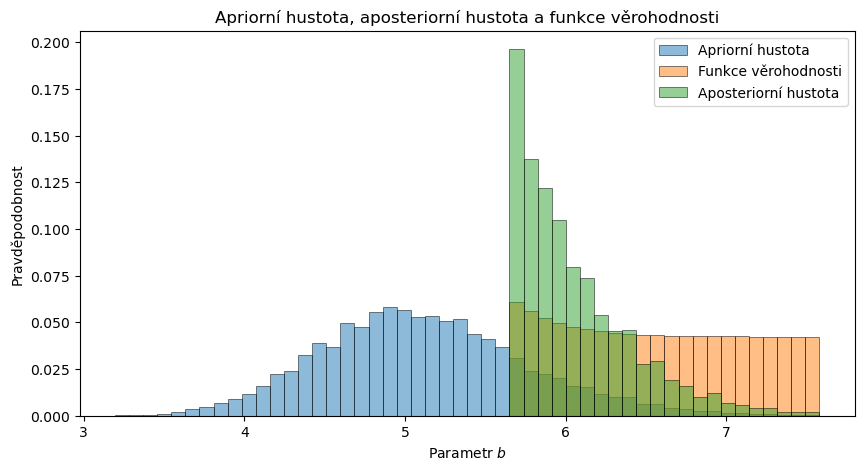

In [13]:
# Vyobrazení výsledného grafu.
fig, ax = plt.subplots(figsize=(10, 5))
plt.title('Apriorní hustota, aposteriorní hustota a funkce věrohodnosti')
plt.xlabel('Parametr $b$')
plt.ylabel('Pravděpodobnost')

plt.bar(bins_centers, hist, width=bins_centers[1]-bins_centers[0], alpha=0.5,
        label='Apriorní hustota', edgecolor='black', linewidth=0.7)
plt.bar(bins_centers, likelihoods, width=bins_centers[1]-bins_centers[0], alpha=0.5,
        label='Funkce věrohodnosti', edgecolor='black', linewidth=0.7)
plt.bar(bins_centers, posterior, width=bins_centers[1]-bins_centers[0], alpha=0.5,
        label='Aposteriorní hustota', edgecolor='black', linewidth=0.7)

ax.legend(loc='best')

plt.show()

Zadání:

<em>2) Z aposteriorní hustoty určete 95% interval spolehlivosti (konfidenční interval) pro
parametr 𝑏.</em>

---

In [14]:
# Výpočet kumulativního součtu.
cdf = np.cumsum(posterior)

# Hledání hodnot na krajích 95% intervalu spolehlivosti.
lower_bound = bins_centers[np.where(cdf >= 0.025)[0][0]]
upper_bound = bins_centers[np.where(cdf >= 0.975)[0][0]]

print("95% Interval spolehlivosti pro parametr b:")
print(f"Dolní hranice: {lower_bound}")
print(f"Horní hranice: {upper_bound}")

95% Interval spolehlivosti pro parametr b:
Dolní hranice: 5.693712028182375
Horní hranice: 7.008910628347767


Zadání:

<em>3) Vyberte dva bodové odhady parametru 𝑏 a spočítejte je.</em>

---

Vybrány byly bodové odhady s využitím střední hodnoty a mediánu.

In [15]:
mean = sum(bins_centers * posterior)

median_index = np.where(cdf >= 0.5)[0][0]
median = bins_centers[median_index]

print("Střední hodnota:")
print(mean)
print()
print("Medián:")
print(median)

Střední hodnota:
6.052771319832352

Medián:
5.956751748215453


## Úloha 2 - Regrese

Zadání:

<em>Disclaimer: data (včetně „příběhu“) jsou vygenerovaná a nemusí mít dobrý obraz v realitě.
Berte proto prosím výsledky z regrese s „rezervou“. Díky.</em>

<em>Podařilo se Vám pomocí stroje času vrátit do doby „zlatého věku“ sociálních sítí a rozhodli
jste se konkurovat Facebooku a Twitteru. V souboru Data_v1.0.csv máte k dispozici záznamy
od více než 500 uživatelů o rychlosti odezvy (sloupec ping [ms]) během používání Vaší
aplikace. Ke každému zápisu máte navíc k dispozici o počtu uživatelů (sloupec ActiveUsers)
v daném okamžiku, o procentu uživatelů, kteří momentálně interagují s prezentovaným
obsahem (sloupec InteractingPct), o procentu uživatelů, kteří jen tupě scrollují po Vaší obdobě
timeline/twitterfeedu (sloupec ScrollingPct) a o operačním systému zařízení ze kterého se
uživatel připojil (OSType). </em>

---

Zadání:

<em>1) Pomocí zpětné eliminace určete vhodný regresní model. Za výchozí „plný“ model
považujte plný kvadratický model (všechny interakce druhého řádu a všechny druhé
mocniny, které dávají smysl).<em>
- <em>Zapište rovnici Vašeho finálního modelu.</em>
- <em>Diskutujte splnění předpokladů lineární regrese a základní regresní
diagnostiky.</em>
- <em>Pokud (až během regresního modelování) identifikujete některé „extrémně
odlehlé hodnoty“ můžete ty „nejodlehlejší“ hodnoty, po alespoň krátkém
zdůvodnění, vyřadit.</em>

---

#### Příprava dat

Načtení dat z xlsx souboru:

In [16]:
# Načtení vstupních dat ze souboru xlsx z listu s názvem "Úloha 2".
df_2 = pd.read_excel(open('Projekt-2_Data.xlsx', 'rb'), sheet_name='Úloha 2')
# Přejmenování atributu 'Ping [ms]' na 'Ping' pro následnou jednodušší práci s atributem.
df_2 = df_2.rename(columns={'Ping [ms]' : 'Ping'})
df_2

,OSType,ActiveUsers,InteractingPct,ScrollingPct,Ping
0,iOS,4113,0.8283,0.1717,47
1,iOS,7549,0.3461,0.6539,46
2,Windows,8855,0.2178,0.7822,55
3,Android,8870,0.0794,0.9206,56
4,MacOS,9559,0.7282,0.2718,76
...,...,...,...,...,...
497,iOS,5315,0.1974,0.8026,28
498,MacOS,1392,0.2373,0.7627,24
499,iOS,6014,0.8112,0.1888,54
500,Android,5118,0.2345,0.7655,39


Jeden z předpokladů regrese je nezávislost reziduí, která bude dále ověřena.

##### Nezávislost reziduí

Nyní je nutné ověřit (ne)závislost reziduí, tedy závislost jednotlivých sloupců ze vstupních dat. Závislost atributů bude ověřena pomocí <em>VIF</em> (z anglického <em>Variance inflation factor</em>). Pro VIF platí, že pokud je hodnota atributu větší než 10, vyplývá, že atribut je kolineární. Takový atribut bude rovnou vyřazen a nebude považován za možný vstup modelu. Zároveň ještě bude získána také korelační matice.

In [17]:
# Výběr nezávislých proměnných.
X = df_2[["ActiveUsers", "InteractingPct", "ScrollingPct"]]
X = add_constant(X)

# Získání hodnot VIF a uložení do dataframe.
vif = pd.Series([variance_inflation_factor(X.values, i) 
                 for i in range(X.shape[1])], 
                 index=X.columns)
vif_df = vif.to_frame()

# Nastavení názvu sloupce.
vif_df.columns = ['VIF']
vif_df

/home/david/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/david/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,VIF
const,0.000000
ActiveUsers,1.001625
InteractingPct,inf
ScrollingPct,inf


In [18]:
# Zobrazení korelace prediktorů.
X.corr()

,const,ActiveUsers,InteractingPct,ScrollingPct
const,NaN,NaN,NaN,NaN
ActiveUsers,NaN,1.000000,0.040275,-0.040275
InteractingPct,NaN,0.040275,1.000000,-1.000000
ScrollingPct,NaN,-0.040275,-1.000000,1.000000


Z výsledků VIF a korelační matice vyplývá, že atributy <em>InteractingPct</em> a <em>ScrollingPct</em> jsou vzájemně kolineární. Následně budou tyto dva atributy vyobrazeny ještě v grafu.

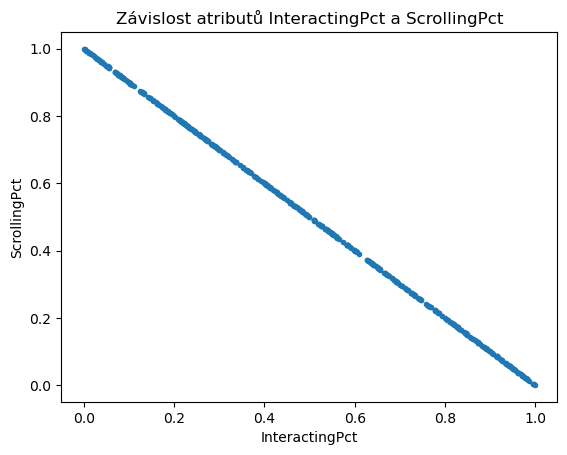

In [19]:
# Vyobrazení závislosti atributů InteractingPct a ScrollingPct.
fig = plt.figure()
ax = fig.add_subplot()

plt.scatter(df_2.InteractingPct, df_2.ScrollingPct, marker='.')
plt.title("Závislost atributů InteractingPct a ScrollingPct")
ax.set_xlabel('InteractingPct')
ax.set_ylabel('ScrollingPct')
plt.show()

Nyní je nutné pro vstup modelu ponechat pouze jeden z výše uvedených kolineárních atributů. Dále proto bude ve vstupu modelu ponechán pouze atribut <em>InteractingPct</em>.

Následně pro potřeby zpětné eliminace bude kategorický atribut <em>OSType</em> převeden na <em>kódování 1 z n</em> (z anglického <em>one-hot encoding</em>).

In [20]:
# Funkce vybraný kategorický atribut převede na kódování 1 z n.
def one_hot_enc(df, column):
    # Ověření, zda se sloupec stále nachází v dataframe.
    # Jedná se o ošetření při vícenásobném zavolání funkce se stejnými parametry.
    if column in df:
        # Získání kódování 1 z n.
        one_hot = pd.get_dummies(df[column], dtype=float, drop_first=True)
        # Odstranění původního kategorického atributu z dataframe.
        df = df.drop(column, axis = 1)
        
        # Navrácení dataframe, který již obsahuje namísto kategorického atributu
        # jeho hodnoty v kódování 1 z n.
        return df.join(one_hot)

    return df

# Převedení kategorického atributu 'OSType' na kódování 1 z n.
df_2 = one_hot_enc(df_2, 'OSType')
df_2

,ActiveUsers,InteractingPct,ScrollingPct,Ping,MacOS,Windows,iOS
0,4113,0.8283,0.1717,47,0.0,0.0,1.0
1,7549,0.3461,0.6539,46,0.0,0.0,1.0
2,8855,0.2178,0.7822,55,0.0,1.0,0.0
3,8870,0.0794,0.9206,56,0.0,0.0,0.0
4,9559,0.7282,0.2718,76,1.0,0.0,0.0
...,...,...,...,...,...,...,...
497,5315,0.1974,0.8026,28,0.0,0.0,1.0
498,1392,0.2373,0.7627,24,1.0,0.0,0.0
499,6014,0.8112,0.1888,54,0.0,0.0,1.0
500,5118,0.2345,0.7655,39,0.0,0.0,0.0


Poté jsou přidány veškeré interakce druhého řádu, které budou následně použity pro vstup modelu. Manuální rozšíření dat o požadované sloupce oproti využití funkcí knihovny <em>statsmodels</em> je především vhodné pro následnou aplikaci zpětné eliminace.

In [21]:
# Funkce slouží pro přidání nového sloupce, který vznikne násobením dvou sloupců
# zadaných jako parametry funkce. Tento nový sloupec je následně přidán do dataframe.
def add_mul_column(df, first_col, second_col):
    # Nastavení názvu nového sloupce.
    new_col_name = first_col + '_' + second_col
    
    # Ověření, zda se sloupec již nenachází v dataframe.
    # Jedná se o ošetření při vícenásobném zavolání funkce se stejnými parametry.
    if new_col_name not in df:
        # Přidání nového sloupce na konec dataframe, který vznikne násobením hodnot dvou původních sloupců.
        df.insert(loc=len(df.columns), column=new_col_name, value=df[first_col] * df[second_col])
        return df
    
    return df

# Přidání všech vhodných interakcí druhého řádu.
df_2 = add_mul_column(df_2, 'ActiveUsers', 'InteractingPct')
df_2 = add_mul_column(df_2, 'ActiveUsers', 'MacOS')
df_2 = add_mul_column(df_2, 'ActiveUsers', 'Windows')
df_2 = add_mul_column(df_2, 'ActiveUsers', 'iOS')
df_2 = add_mul_column(df_2, 'InteractingPct', 'MacOS')
df_2 = add_mul_column(df_2, 'InteractingPct', 'Windows')
df_2 = add_mul_column(df_2, 'InteractingPct', 'iOS')

df_2 = add_mul_column(df_2, 'ActiveUsers', 'ActiveUsers')
df_2 = add_mul_column(df_2, 'InteractingPct', 'InteractingPct')

df_2

,ActiveUsers,InteractingPct,ScrollingPct,Ping,MacOS,Windows,iOS,ActiveUsers_InteractingPct,ActiveUsers_MacOS,ActiveUsers_Windows,ActiveUsers_iOS,InteractingPct_MacOS,InteractingPct_Windows,InteractingPct_iOS,ActiveUsers_ActiveUsers,InteractingPct_InteractingPct
0,4113,0.8283,0.1717,47,0.0,0.0,1.0,3406.7979,0.0,0.0,4113.0,0.0000,0.0000,0.8283,16916769,0.686081
1,7549,0.3461,0.6539,46,0.0,0.0,1.0,2612.7089,0.0,0.0,7549.0,0.0000,0.0000,0.3461,56987401,0.119785
2,8855,0.2178,0.7822,55,0.0,1.0,0.0,1928.6190,0.0,8855.0,0.0,0.0000,0.2178,0.0000,78411025,0.047437
3,8870,0.0794,0.9206,56,0.0,0.0,0.0,704.2780,0.0,0.0,0.0,0.0000,0.0000,0.0000,78676900,0.006304
4,9559,0.7282,0.2718,76,1.0,0.0,0.0,6960.8638,9559.0,0.0,0.0,0.7282,0.0000,0.0000,91374481,0.530275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,5315,0.1974,0.8026,28,0.0,0.0,1.0,1049.1810,0.0,0.0,5315.0,0.0000,0.0000,0.1974,28249225,0.038967
498,1392,0.2373,0.7627,24,1.0,0.0,0.0,330.3216,1392.0,0.0,0.0,0.2373,0.0000,0.0000,1937664,0.056311
499,6014,0.8112,0.1888,54,0.0,0.0,1.0,4878.5568,0.0,0.0,6014.0,0.0000,0.0000,0.8112,36168196,0.658045
500,5118,0.2345,0.7655,39,0.0,0.0,0.0,1200.1710,0.0,0.0,0.0,0.0000,0.0000,0.0000,26193924,0.054990


#### Vyobrazení původních dat:

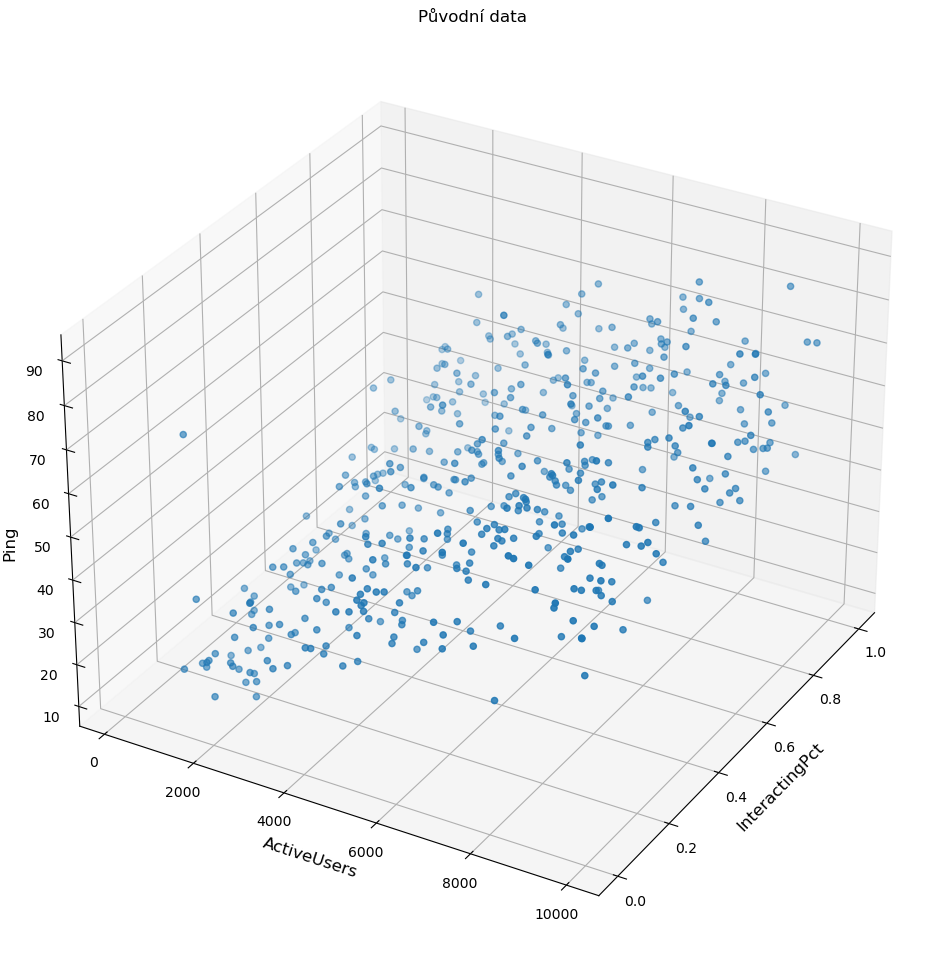

In [22]:
# Vyobrazení grafu obsahujícího původní data.
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

x = np.arange(0, 10000, 100)
y = np.arange(0.0, 1.0, 0.01)
X, Y = np.meshgrid(x, y)

# Vykreslení původních dat.
ax.scatter(df_2.ActiveUsers, df_2.InteractingPct, df_2.Ping, marker='o')

plt.title("Původní data")

ax.set_xlabel('ActiveUsers', fontsize=12)
ax.set_ylabel('InteractingPct', fontsize=12)
ax.zaxis._axinfo['juggled'] = (1, 2, 2) 
ax.set_zlabel('Ping', fontsize=12, rotation=90)

plt.show()

#### Definice plného modelu:

Dalším krokem po přípravě dat je samotná definice plného modelu, tedy modelu, který obsahuje veškeré smysluplné interakce druhého řádu. Na základě skutečnosti, že atributy <em>MacOS</em>, <em>Windows</em> a <em>iOS</em> vznikly pomocí kódování 1 z n z kategorického atributu <em>OSType</em>, nemá význam pro definici formule uvažovat jejich druhé mocniny. Následné atributy značeny s využitím znaku '\_' představují atributy, které vznikly násobením daných dvou atributů. Například atribut <em>ActiveUsers_InteractingPct</em> vznikl výpočtem ```ActiveUsers * InteractingPct``` s využitím dříve definované funkce ```add_mul_column()```.

In [23]:
# Vytvoření plného modelu.
formula_definition = 'Ping ~ ActiveUsers + InteractingPct + MacOS + Windows + iOS + ' + \
    'ActiveUsers_InteractingPct + ' + \
    'ActiveUsers_MacOS + ' + \
    'ActiveUsers_Windows + ' + \
    'ActiveUsers_iOS + ' + \
    'InteractingPct_MacOS + ' + \
    'InteractingPct_Windows + ' + \
    'InteractingPct_iOS + ' + \
    'ActiveUsers_ActiveUsers + ' + \
    'InteractingPct_InteractingPct'
full_model = smf.ols(formula=formula_definition, data=df_2)
full_model_fit = full_model.fit()

# Výpis souhrnu informací o modelu.
full_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     187.9
Date:                Sat, 16 Dec 2023   Prob (F-statistic):          5.18e-186
Time:                        18:14:41   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3227.
Df Residuals:                     487   BIC:                             3290.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.3388      2.354     -0.144      0.886      -4.965       4.287
ActiveUsers                       0.0100      0.001     17.571      0.000       0.009       0.011
InteractingPct                   37.6062      4.567      8.234      0.000      28.633      46.580
MacOS                             2.0017      2.260      0.886      0.376      -2.440       6.443
Windows                           7.8174      2.217      3.526      0.000       3.461      12.174
iOS                              -0.0483      2.265     -0.021      0.983      -4.499       4.403
ActiveUsers_InteractingPct       -0.0031      0.000     -8.532      0.000      -0.004      -0.002
ActiveUsers_MacOS                 0.0014      0.000      4.536      0.000       0.001       0.002
ActiveUsers_Windows              -0.0008      0.000     -2.505      0.013      -0.001      -0.000
ActiveUsers_iOS                  -0.0011      0.000     -3.369      0.001      -0.002      -0.000
InteractingPct_MacOS             -0.3566      2.530     -0.141      0.888      -5.327       4.614
InteractingPct_Windows            0.4260      2.721      0.157      0.876      -4.919       5.771
InteractingPct_iOS                0.2678      2.691      0.100      0.921      -5.020       5.556
ActiveUsers_ActiveUsers        -4.17e-07    4.4e-08     -9.469      0.000   -5.03e-07    -3.3e-07
InteractingPct_InteractingPct    -3.7258      3.492     -1.067      0.287     -10.587       3.135
==============================================================================
Omnibus:                      228.442   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3152.488
Skew:                           1.603   Prob(JB):                         0.00
Kurtosis:                      14.851   Cond. No.                     1.06e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Následně bude vypočítána hodnota VIF a také korelační matice pro jednotlivé prediktory.

In [24]:
X = pd.DataFrame(full_model.exog, columns=full_model.exog_names)

# Získání hodnot VIF a uložení do dataframe.
vif = pd.Series([variance_inflation_factor(X.values, i) 
                 for i in range(X.shape[1])], 
                 index=X.columns)
vif_df = vif.to_frame()

# Nastavení názvu sloupce.
vif_df.columns = ['VIF']

vif_df

,VIF
Intercept,79.081437
ActiveUsers,30.108570
InteractingPct,26.021105
MacOS,14.530955
Windows,13.726080
iOS,13.164975
ActiveUsers_InteractingPct,8.851002
ActiveUsers_MacOS,10.454073
ActiveUsers_Windows,10.189613
ActiveUsers_iOS,9.061267


In [25]:
# Zobrazení korelace prediktorů.
X.corr()

,Intercept,ActiveUsers,InteractingPct,MacOS,Windows,iOS,ActiveUsers_InteractingPct,ActiveUsers_MacOS,ActiveUsers_Windows,ActiveUsers_iOS,InteractingPct_MacOS,InteractingPct_Windows,InteractingPct_iOS,ActiveUsers_ActiveUsers,InteractingPct_InteractingPct
Intercept,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ActiveUsers,NaN,1.000000,0.040275,-0.000136,0.003135,-0.063206,0.591746,0.243697,0.258029,0.189859,-0.004409,0.035105,-0.045884,0.977081,0.025793
InteractingPct,NaN,0.040275,1.000000,0.086466,-0.016964,-0.062634,0.752979,0.072359,0.010807,-0.050601,0.388633,0.248636,0.244987,0.033100,0.967446
MacOS,NaN,-0.000136,0.086466,1.000000,-0.371550,-0.341322,0.052512,0.881244,-0.325207,-0.296440,0.821075,-0.309767,-0.272791,-0.004621,0.108126
Windows,NaN,0.003135,-0.016964,-0.371550,1.000000,-0.334506,0.002608,-0.327426,0.875271,-0.290521,-0.305071,0.833716,-0.267344,0.009084,-0.042324
iOS,NaN,-0.063206,-0.062634,-0.341322,-0.334506,1.000000,-0.084945,-0.300788,-0.292783,0.868507,-0.280251,-0.278883,0.799219,-0.055587,-0.053518
ActiveUsers_InteractingPct,NaN,0.591746,0.752979,0.052512,0.002608,-0.084945,1.000000,0.193768,0.163826,0.053582,0.271050,0.210449,0.132465,0.576716,0.720732
ActiveUsers_MacOS,NaN,0.243697,0.072359,0.881244,-0.327426,-0.300788,0.193768,1.000000,-0.286586,-0.261236,0.719630,-0.272980,-0.240395,0.229636,0.086850
ActiveUsers_Windows,NaN,0.258029,0.010807,-0.325207,0.875271,-0.292783,0.163826,-0.286586,1.000000,-0.254284,-0.267019,0.759496,-0.233998,0.261283,-0.017146
ActiveUsers_iOS,NaN,0.189859,-0.050601,-0.296440,-0.290521,0.868507,0.053582,-0.261236,-0.254284,1.000000,-0.243400,-0.242212,0.698777,0.184717,-0.050135


Vyobrazení plného modelu:

Parametry plného modelu:
Intercept                       -3.388459e-01
ActiveUsers                      1.002406e-02
InteractingPct                   3.760617e+01
MacOS                            2.001747e+00
Windows                          7.817378e+00
iOS                             -4.833230e-02
ActiveUsers_InteractingPct      -3.086297e-03
ActiveUsers_MacOS                1.397350e-03
ActiveUsers_Windows             -7.618681e-04
ActiveUsers_iOS                 -1.058353e-03
InteractingPct_MacOS            -3.565678e-01
InteractingPct_Windows           4.260464e-01
InteractingPct_iOS               2.678486e-01
ActiveUsers_ActiveUsers         -4.169698e-07
InteractingPct_InteractingPct   -3.725768e+00
dtype: float64


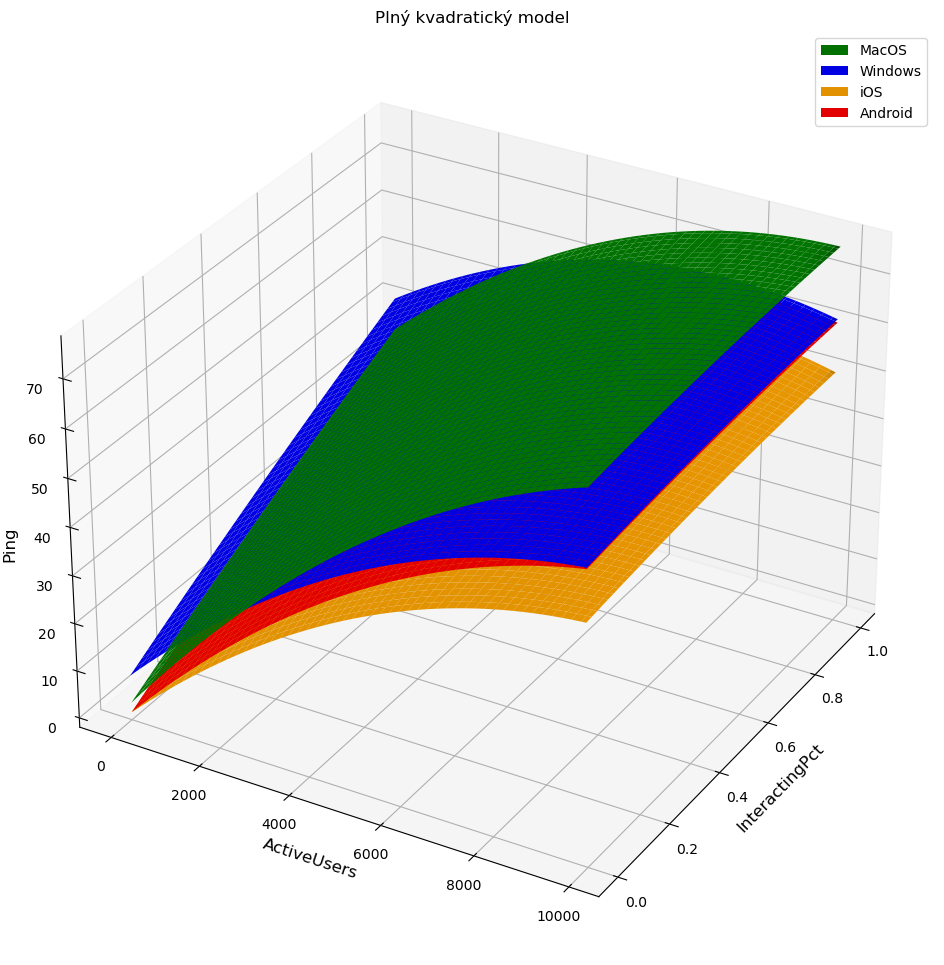

In [26]:
print('Parametry plného modelu:')
print(full_model_fit.params)

# Vyobrazení grafu plného modelu.
fig = plt.figure(figsize=(12,12)) 
ax = fig.add_subplot(111, projection='3d')

x = np.arange(0, 10000, 100)
y = np.arange(0.0, 1.0, 0.01)
X, Y = np.meshgrid(x, y)

# Získání hodnot prediktorů pro jednotlivé OS.
zs_macos = full_model_fit.params['Intercept'] + \
    full_model_fit.params['MacOS'] + \
    full_model_fit.params['ActiveUsers'] * X + \
    full_model_fit.params['ActiveUsers_MacOS'] * X + \
    full_model_fit.params['InteractingPct'] * Y + \
    full_model_fit.params['InteractingPct_MacOS'] * Y + \
    full_model_fit.params['ActiveUsers_InteractingPct'] * X * Y + \
    full_model_fit.params['ActiveUsers_ActiveUsers'] * X * X + \
    full_model_fit.params['InteractingPct_InteractingPct'] * Y * Y

zs_win = full_model_fit.params['Intercept'] + \
    full_model_fit.params['Windows'] + \
    full_model_fit.params['ActiveUsers'] * X + \
    full_model_fit.params['ActiveUsers_Windows'] * X + \
    full_model_fit.params['InteractingPct'] * Y + \
    full_model_fit.params['InteractingPct_Windows'] * Y + \
    full_model_fit.params['ActiveUsers_InteractingPct'] * X * Y + \
    full_model_fit.params['ActiveUsers_ActiveUsers'] * X * X + \
    full_model_fit.params['InteractingPct_InteractingPct'] * Y * Y

zs_ios = full_model_fit.params['Intercept'] + \
    full_model_fit.params['iOS'] + \
    full_model_fit.params['ActiveUsers'] * X + \
    full_model_fit.params['ActiveUsers_iOS'] * X + \
    full_model_fit.params['InteractingPct'] * Y + \
    full_model_fit.params['InteractingPct_iOS'] * Y + \
    full_model_fit.params['ActiveUsers_InteractingPct'] * X * Y + \
    full_model_fit.params['ActiveUsers_ActiveUsers'] * X * X + \
    full_model_fit.params['InteractingPct_InteractingPct'] * Y * Y

zs_android = full_model_fit.params['Intercept'] + \
    full_model_fit.params['ActiveUsers'] * X + \
    full_model_fit.params['InteractingPct'] * Y + \
    full_model_fit.params['ActiveUsers_InteractingPct'] * X * Y + \
    full_model_fit.params['ActiveUsers_ActiveUsers'] * X * X + \
    full_model_fit.params['InteractingPct_InteractingPct'] * Y * Y

Z_macos = zs_macos.reshape(X.shape)
Z_win = zs_win.reshape(X.shape)
Z_ios = zs_ios.reshape(X.shape)
Z_android = zs_android.reshape(X.shape)

# Vyobrazení povrchu pro jednotlivé OS.
macos_surface = ax.plot_surface(X, Y, Z_macos, color='green', label='MacOS')
windows_surface = ax.plot_surface(X, Y, Z_win, color='blue', label='Windows')
ios_surface = ax.plot_surface(X, Y, Z_ios, color='orange', label='iOS')
android_surface = ax.plot_surface(X, Y, Z_android, color='red', label='Android')

# Ošetření problému s matplotlib legendou.
# Více viz:
# https://stackoverflow.com/questions/55531760/is-there-a-way-to-label-multiple-3d-surfaces-in-matplotlib
macos_surface._facecolors2d = macos_surface._facecolor3d
macos_surface._edgecolors2d = macos_surface._edgecolor3d

windows_surface._facecolors2d = windows_surface._facecolor3d
windows_surface._edgecolors2d = windows_surface._edgecolor3d

ios_surface._facecolors2d = ios_surface._facecolor3d
ios_surface._edgecolors2d = ios_surface._edgecolor3d

android_surface._facecolors2d = android_surface._facecolor3d
android_surface._edgecolors2d = android_surface._edgecolor3d

plt.title("Plný kvadratický model")
ax.legend(loc='best')
ax.set_xlabel('ActiveUsers', fontsize=12)
ax.set_ylabel('InteractingPct', fontsize=12)
ax.zaxis._axinfo['juggled'] = (1, 2, 2) 
ax.set_zlabel('Ping', fontsize=12, rotation=90)

plt.show()

#### Získání výsledného modelu pomocí algoritmu zpětné eliminace:

Nyní bude z plného modelu dle jednotlivých kroků algoritmu zpětné eliminace vytvořen výsledný model. Algoritmus začíná tak, že nejprve musí být určena hladina významnosti, která bude definovat hladinu určující, zda daný prediktor zůstane v modelu dle jeho P-hodnoty. Pro účely projektu byla zvolena hladina 0.05. Algoritmus vychází z plného modelu, pro který byly uvedeny jeho výsledky včetně P-hodnot pro všechny prediktory. Následně započne cyklická část algoritmu, která pokračuje, dokud se v modelu nachází prediktor, pro který platí, že P-hodnota > 0.05:

- Je vybrán prediktor s největší P-hodnotou.
    - Pokud platí, že P-hodnota > 0.05, prediktor je odstraněn.
    - V opačném případě algoritmus končí a je vytvořen výsledný model.

__Odstranění prediktoru iOS:__

In [27]:
# Odstraneni iOS
formula_definition = 'Ping ~ ActiveUsers + InteractingPct + MacOS + Windows + ' + \
    'ActiveUsers_InteractingPct + ' + \
    'ActiveUsers_MacOS + ' + \
    'ActiveUsers_Windows + ' + \
    'ActiveUsers_iOS + ' + \
    'InteractingPct_MacOS + ' + \
    'InteractingPct_Windows + ' + \
    'InteractingPct_iOS + ' + \
    'ActiveUsers_ActiveUsers + ' + \
    'InteractingPct_InteractingPct'
model = smf.ols(formula=formula_definition, data=df_2)
model_fit = model.fit()

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     202.8
Date:                Sat, 16 Dec 2023   Prob (F-statistic):          3.57e-187
Time:                        18:14:43   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3225.
Df Residuals:                     488   BIC:                             3284.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.3714      1.793     -0.207      0.836      -3.894       3.151
ActiveUsers                       0.0100      0.001     18.742      0.000       0.009       0.011
InteractingPct                   37.6338      4.375      8.603      0.000      29.038      46.229
MacOS                             2.0290      1.863      1.089      0.277      -1.632       5.690
Windows                           7.8447      1.810      4.335      0.000       4.289      11.400
ActiveUsers_InteractingPct       -0.0031      0.000     -8.590      0.000      -0.004      -0.002
ActiveUsers_MacOS                 0.0014      0.000      5.017      0.000       0.001       0.002
ActiveUsers_Windows              -0.0008      0.000     -2.796      0.005      -0.001      -0.000
ActiveUsers_iOS                  -0.0011      0.000     -5.155      0.000      -0.001      -0.001
InteractingPct_MacOS             -0.3729      2.408     -0.155      0.877      -5.104       4.358
InteractingPct_Windows            0.4095      2.605      0.157      0.875      -4.709       5.528
InteractingPct_iOS                0.2368      2.262      0.105      0.917      -4.208       4.682
ActiveUsers_ActiveUsers       -4.171e-07   4.38e-08     -9.524      0.000   -5.03e-07   -3.31e-07
InteractingPct_InteractingPct    -3.7327      3.473     -1.075      0.283     -10.557       3.092
==============================================================================
Omnibus:                      228.481   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3153.673
Skew:                           1.603   Prob(JB):                         0.00
Kurtosis:                      14.853   Cond. No.                     9.61e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.61e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

__Odstranění prediktoru InteractingPct_iOS:__

In [28]:
# Odstraneni InteractingPct_iOS
formula_definition = 'Ping ~ ActiveUsers + InteractingPct + MacOS + Windows + ' + \
    'ActiveUsers_InteractingPct + ' + \
    'ActiveUsers_MacOS + ' + \
    'ActiveUsers_Windows + ' + \
    'ActiveUsers_iOS + ' + \
    'InteractingPct_MacOS + ' + \
    'InteractingPct_Windows + ' + \
    'ActiveUsers_ActiveUsers + ' + \
    'InteractingPct_InteractingPct'
model = smf.ols(formula=formula_definition, data=df_2)
model_fit = model.fit()

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     220.1
Date:                Sat, 16 Dec 2023   Prob (F-statistic):          2.36e-188
Time:                        18:14:43   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3223.
Df Residuals:                     489   BIC:                             3278.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.3703      1.791     -0.207      0.836      -3.889       3.149
ActiveUsers                       0.0100      0.001     19.067      0.000       0.009       0.011
InteractingPct                   37.7781      4.148      9.108      0.000      29.628      45.928
MacOS                             2.0221      1.860      1.087      0.278      -1.633       5.677
Windows                           7.8395      1.807      4.338      0.000       4.289      11.390
ActiveUsers_InteractingPct       -0.0031      0.000     -8.657      0.000      -0.004      -0.002
ActiveUsers_MacOS                 0.0014      0.000      5.392      0.000       0.001       0.002
ActiveUsers_Windows              -0.0008      0.000     -2.941      0.003      -0.001      -0.000
ActiveUsers_iOS                  -0.0010      0.000     -8.061      0.000      -0.001      -0.001
InteractingPct_MacOS             -0.4989      2.084     -0.239      0.811      -4.593       3.595
InteractingPct_Windows            0.2836      2.308      0.123      0.902      -4.252       4.819
ActiveUsers_ActiveUsers       -4.168e-07   4.37e-08     -9.539      0.000   -5.03e-07   -3.31e-07
InteractingPct_InteractingPct    -3.7301      3.470     -1.075      0.283     -10.547       3.087
==============================================================================
Omnibus:                      228.487   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3154.636
Skew:                           1.603   Prob(JB):                         0.00
Kurtosis:                      14.855   Cond. No.                     9.26e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.26e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

__Odstranění prediktoru InteractingPct_Windows:__

In [29]:
# Odstraneni InteractingPct_Windows
formula_definition = 'Ping ~ ActiveUsers + InteractingPct + MacOS + Windows + ' + \
    'ActiveUsers_InteractingPct + ' + \
    'ActiveUsers_MacOS + ' + \
    'ActiveUsers_Windows + ' + \
    'ActiveUsers_iOS + ' + \
    'InteractingPct_MacOS + ' + \
    'ActiveUsers_ActiveUsers + ' + \
    'InteractingPct_InteractingPct'
model = smf.ols(formula=formula_definition, data=df_2)
model_fit = model.fit()

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     240.6
Date:                Sat, 16 Dec 2023   Prob (F-statistic):          1.50e-189
Time:                        18:14:43   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3221.
Df Residuals:                     490   BIC:                             3271.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.4127      1.756     -0.235      0.814      -3.862       3.037
ActiveUsers                       0.0100      0.001     19.086      0.000       0.009       0.011
InteractingPct                   37.8763      4.066      9.315      0.000      29.887      45.865
MacOS                             2.0635      1.828      1.129      0.259      -1.528       5.655
Windows                           7.9604      1.514      5.258      0.000       4.985      10.935
ActiveUsers_InteractingPct       -0.0031      0.000     -8.669      0.000      -0.004      -0.002
ActiveUsers_MacOS                 0.0014      0.000      5.401      0.000       0.001       0.002
ActiveUsers_Windows              -0.0008      0.000     -2.944      0.003      -0.001      -0.000
ActiveUsers_iOS                  -0.0010      0.000     -8.068      0.000      -0.001      -0.001
InteractingPct_MacOS             -0.5925      1.938     -0.306      0.760      -4.399       3.214
ActiveUsers_ActiveUsers       -4.168e-07   4.37e-08     -9.548      0.000   -5.03e-07   -3.31e-07
InteractingPct_InteractingPct    -3.7303      3.466     -1.076      0.282     -10.541       3.080
==============================================================================
Omnibus:                      228.480   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3153.948
Skew:                           1.603   Prob(JB):                         0.00
Kurtosis:                      14.853   Cond. No.                     9.14e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.14e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

__Odstranění prediktoru InteractingPct_MacOS:__

In [30]:
# Odstraneni InteractingPct_MacOS
formula_definition = 'Ping ~ ActiveUsers + InteractingPct + MacOS + Windows + ' + \
    'ActiveUsers_InteractingPct + ' + \
    'ActiveUsers_MacOS + ' + \
    'ActiveUsers_Windows + ' + \
    'ActiveUsers_iOS + ' + \
    'ActiveUsers_ActiveUsers + ' + \
    'InteractingPct_InteractingPct'
model = smf.ols(formula=formula_definition, data=df_2)
model_fit = model.fit()

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     265.2
Date:                Sat, 16 Dec 2023   Prob (F-statistic):          9.41e-191
Time:                        18:14:43   Log-Likelihood:                -1598.5
No. Observations:                 502   AIC:                             3219.
Df Residuals:                     491   BIC:                             3265.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.3369      1.736     -0.194      0.846      -3.749       3.075
ActiveUsers                       0.0100      0.001     19.112      0.000       0.009       0.011
InteractingPct                   37.7205      4.030      9.360      0.000      29.802      45.639
MacOS                             1.7623      1.538      1.146      0.252      -1.260       4.784
Windows                           7.9544      1.513      5.259      0.000       4.983      10.926
ActiveUsers_InteractingPct       -0.0031      0.000     -8.674      0.000      -0.004      -0.002
ActiveUsers_MacOS                 0.0014      0.000      5.404      0.000       0.001       0.002
ActiveUsers_Windows              -0.0008      0.000     -2.943      0.003      -0.001      -0.000
ActiveUsers_iOS                  -0.0010      0.000     -8.084      0.000      -0.001      -0.001
ActiveUsers_ActiveUsers        -4.17e-07   4.36e-08     -9.563      0.000   -5.03e-07   -3.31e-07
InteractingPct_InteractingPct    -3.7675      3.461     -1.089      0.277     -10.567       3.032
==============================================================================
Omnibus:                      229.699   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3207.912
Skew:                           1.611   Prob(JB):                         0.00
Kurtosis:                      14.958   Cond. No.                     9.12e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.12e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

__Odstranění prediktoru InteractingPct_InteractingPct:__

In [31]:
# Odstraneni InteractingPct_InteractingPct
formula_definition = 'Ping ~ ActiveUsers + InteractingPct + MacOS + Windows + ' + \
    'ActiveUsers_InteractingPct + ' + \
    'ActiveUsers_MacOS + ' + \
    'ActiveUsers_Windows + ' + \
    'ActiveUsers_iOS + ' + \
    'ActiveUsers_ActiveUsers'
model = smf.ols(formula=formula_definition, data=df_2)
model_fit = model.fit()

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Ping   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     294.4
Date:                Sat, 16 Dec 2023   Prob (F-statistic):          9.61e-192
Time:                        18:14:43   Log-Likelihood:                -1599.1
No. Observations:                 502   AIC:                             3218.
Df Residuals:                     492   BIC:                             3260.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.2577      1.649      0.156      0.876      -2.981       3.497
ActiveUsers                    0.0100      0.001     19.101      0.000       0.009       0.011
InteractingPct                33.9892      2.120     16.030      0.000      29.823      38.155
MacOS                          1.6826      1.537      1.095      0.274      -1.337       4.702
Windows                        7.9718      1.513      5.270      0.000       5.000      10.944
ActiveUsers_InteractingPct    -0.0031      0.000     -8.677      0.000      -0.004      -0.002
ActiveUsers_MacOS              0.0014      0.000      5.430      0.000       0.001       0.002
ActiveUsers_Windows           -0.0007      0.000     -2.919      0.004      -0.001      -0.000
ActiveUsers_iOS               -0.0010      0.000     -8.079      0.000      -0.001      -0.001
ActiveUsers_ActiveUsers    -4.163e-07   4.36e-08     -9.547      0.000   -5.02e-07   -3.31e-07
==============================================================================
Omnibus:                      230.835   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3266.312
Skew:                           1.617   Prob(JB):                         0.00
Kurtosis:                      15.070   Cond. No.                     4.22e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.22e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

__Odstranění prediktoru MacOS:__

In [32]:
# Odstraneni MacOS
formula_definition = 'Ping ~ ActiveUsers + InteractingPct + Windows + ' + \
    'ActiveUsers_InteractingPct + ' + \
    'ActiveUsers_MacOS + ' + \
    'ActiveUsers_Windows + ' + \
    'ActiveUsers_iOS + ' + \
    'ActiveUsers_ActiveUsers'
model = smf.ols(formula=formula_definition, data=df_2)
model_fit = model.fit()

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Ping   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     330.9
Date:                Sat, 16 Dec 2023   Prob (F-statistic):          9.30e-193
Time:                        18:14:44   Log-Likelihood:                -1599.7
No. Observations:                 502   AIC:                             3217.
Df Residuals:                     493   BIC:                             3255.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.7923      1.575      0.503      0.615      -2.302       3.887
ActiveUsers                    0.0099      0.001     19.167      0.000       0.009       0.011
InteractingPct                34.2568      2.107     16.262      0.000      30.118      38.396
Windows                        7.3575      1.405      5.236      0.000       4.597      10.118
ActiveUsers_InteractingPct    -0.0031      0.000     -8.832      0.000      -0.004      -0.002
ActiveUsers_MacOS              0.0017      0.000     13.603      0.000       0.001       0.002
ActiveUsers_Windows           -0.0007      0.000     -2.710      0.007      -0.001      -0.000
ActiveUsers_iOS               -0.0011      0.000     -8.118      0.000      -0.001      -0.001
ActiveUsers_ActiveUsers    -4.146e-07   4.36e-08     -9.511      0.000      -5e-07   -3.29e-07
==============================================================================
Omnibus:                      242.580   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3742.643
Skew:                           1.701   Prob(JB):                         0.00
Kurtosis:                      15.937   Cond. No.                     4.21e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.21e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Nyní po skončení algoritmu zpětné eliminace budou ještě vypočítány hodnoty VIF a korelační matice pro jednotlivé ponechané prediktory.

In [33]:
X = pd.DataFrame(model.exog, columns=model.exog_names)

# Získání hodnot VIF a uložení do dataframe.
vif = pd.Series([variance_inflation_factor(X.values, i) 
                 for i in range(X.shape[1])], 
                 index=X.columns)
vif_df = vif.to_frame()

# Nastavení názvu sloupce.
vif_df.columns = ['VIF']
vif_df

,VIF
Intercept,35.644330
ActiveUsers,24.981312
InteractingPct,5.576012
Windows,5.551936
ActiveUsers_InteractingPct,8.566008
ActiveUsers_MacOS,1.657555
ActiveUsers_Windows,6.474746
ActiveUsers_iOS,1.550683
ActiveUsers_ActiveUsers,22.204978


In [34]:
# Zobrazení korelace prediktorů.
X.corr()

,Intercept,ActiveUsers,InteractingPct,Windows,ActiveUsers_InteractingPct,ActiveUsers_MacOS,ActiveUsers_Windows,ActiveUsers_iOS,ActiveUsers_ActiveUsers
Intercept,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ActiveUsers,NaN,1.000000,0.040275,0.003135,0.591746,0.243697,0.258029,0.189859,0.977081
InteractingPct,NaN,0.040275,1.000000,-0.016964,0.752979,0.072359,0.010807,-0.050601,0.033100
Windows,NaN,0.003135,-0.016964,1.000000,0.002608,-0.327426,0.875271,-0.290521,0.009084
ActiveUsers_InteractingPct,NaN,0.591746,0.752979,0.002608,1.000000,0.193768,0.163826,0.053582,0.576716
ActiveUsers_MacOS,NaN,0.243697,0.072359,-0.327426,0.193768,1.000000,-0.286586,-0.261236,0.229636
ActiveUsers_Windows,NaN,0.258029,0.010807,0.875271,0.163826,-0.286586,1.000000,-0.254284,0.261283
ActiveUsers_iOS,NaN,0.189859,-0.050601,-0.290521,0.053582,-0.261236,-0.254284,1.000000,0.184717
ActiveUsers_ActiveUsers,NaN,0.977081,0.033100,0.009084,0.576716,0.229636,0.261283,0.184717,1.000000


Na základě hodnot VIF a i z korelační matice je možné určit, že prediktory <em>ActiveUsers</em> a <em>ActiveUsers_ActiveUsers</em> jsou vzájemně závislé. Danou skutečnost lze odvodit z toho, že prediktor <em>ActiveUsers_ActiveUsers</em> vznikl získáním druhé mocniny prediktoru <em>ActiveUsers</em>. Proto bude ve výsledném modelu ponechán pouze jeden, a to <em>ActiveUsers</em>.

__Odstranění prediktoru ActiveUsers_ActiveUsers:__

In [35]:
# Odstraneni ActiveUsers_ActiveUsers
formula_definition = 'Ping ~ ActiveUsers + InteractingPct + Windows + ' + \
    'ActiveUsers_InteractingPct + ' + \
    'ActiveUsers_MacOS + ' + \
    'ActiveUsers_Windows + ' + \
    'ActiveUsers_iOS'
model = smf.ols(formula=formula_definition, data=df_2)
model_fit = model.fit()

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Ping   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     309.3
Date:                Sat, 16 Dec 2023   Prob (F-statistic):          4.99e-176
Time:                        18:14:44   Log-Likelihood:                -1642.0
No. Observations:                 502   AIC:                             3300.
Df Residuals:                     494   BIC:                             3334.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      9.9196      1.357      7.309      0.000       7.253      12.586
ActiveUsers                    0.0055      0.000     22.743      0.000       0.005       0.006
InteractingPct                35.2710      2.286     15.426      0.000      30.779      39.763
Windows                        7.7665      1.526      5.088      0.000       4.767      10.766
ActiveUsers_InteractingPct    -0.0033      0.000     -8.504      0.000      -0.004      -0.003
ActiveUsers_MacOS              0.0017      0.000     12.726      0.000       0.001       0.002
ActiveUsers_Windows           -0.0007      0.000     -2.840      0.005      -0.001      -0.000
ActiveUsers_iOS               -0.0010      0.000     -7.445      0.000      -0.001      -0.001
==============================================================================
Omnibus:                      123.688   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              663.242
Skew:                           0.959   Prob(JB):                    9.53e-145
Kurtosis:                       8.294   Cond. No.                     6.56e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.56e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Následně budou ještě jednou vypočítány hodnoty VIF a korelační matice.

In [36]:
X = pd.DataFrame(model.exog, columns=model.exog_names)

# Získání hodnot VIF a uložení do dataframe.
vif = pd.Series([variance_inflation_factor(X.values, i) 
                 for i in range(X.shape[1])], 
                 index=X.columns)
vif_df = vif.to_frame()

# Nastavení názvu sloupce.
vif_df.columns = ['VIF']
vif_df

,VIF
Intercept,22.411971
ActiveUsers,4.567019
InteractingPct,5.561726
Windows,5.546736
ActiveUsers_InteractingPct,8.550677
ActiveUsers_MacOS,1.656643
ActiveUsers_Windows,6.464752
ActiveUsers_iOS,1.550671


In [37]:
# Zobrazení korelace prediktorů.
X.corr()

,Intercept,ActiveUsers,InteractingPct,Windows,ActiveUsers_InteractingPct,ActiveUsers_MacOS,ActiveUsers_Windows,ActiveUsers_iOS
Intercept,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ActiveUsers,NaN,1.000000,0.040275,0.003135,0.591746,0.243697,0.258029,0.189859
InteractingPct,NaN,0.040275,1.000000,-0.016964,0.752979,0.072359,0.010807,-0.050601
Windows,NaN,0.003135,-0.016964,1.000000,0.002608,-0.327426,0.875271,-0.290521
ActiveUsers_InteractingPct,NaN,0.591746,0.752979,0.002608,1.000000,0.193768,0.163826,0.053582
ActiveUsers_MacOS,NaN,0.243697,0.072359,-0.327426,0.193768,1.000000,-0.286586,-0.261236
ActiveUsers_Windows,NaN,0.258029,0.010807,0.875271,0.163826,-0.286586,1.000000,-0.254284
ActiveUsers_iOS,NaN,0.189859,-0.050601,-0.290521,0.053582,-0.261236,-0.254284,1.000000


Nyní již jsou hodnoty VIF v požadovaném rozsahu a je získán výsledný model dle algoritmu (ještě ovšem se nejedná o úplně konečný model, protože ještě bude nutné odstranit odlehlé hodnoty, jak bude následně provedeno).

Po odstranění prediktoru <em>ActiveUsers_ActiveUsers</em> se změnila hodnota <em>R-squared</em> z hodnoty ```0.843``` na hodnotu ```0.814```, ovšem i přes snížení této hodnoty lze argumentovat, že se zároveň snížila celková složitost modelu, a tedy může být daný krok eliminace prediktoru proveden.

Rovnice finálního modelu po aplikaci algoritmu je následující:

In [38]:
def get_reg_eq(model_fit):
    eq = f"y = {model_fit.params.Intercept:.6f}"

    for term in model_fit.params.index[1:]:
        eq += f" + {model_fit.params[term]:.6f} * {term}"
    
    print(f"Regression equation: {eq}")

get_reg_eq(model_fit)

Regression equation: y = 9.919642 + 0.005472 * ActiveUsers + 35.271023 * InteractingPct + 7.766522 * Windows + -0.003274 * ActiveUsers_InteractingPct + 0.001690 * ActiveUsers_MacOS + -0.000745 * ActiveUsers_Windows + -0.001048 * ActiveUsers_iOS


#### Ověřování linearity

Z předpokladu vyplývá, že existuje lineární závislost mezi prediktorama a závislou proměnnou. Následně bude vyobrazen vztah reálných hodnot a predikovaných hodnot.

In [39]:
new_col_name = 'prediction'
    
if new_col_name not in df_2:
    df_2.insert(loc=len(df_2.columns), column=new_col_name, value=model_fit.fittedvalues)

df_2['prediction']

0      46.177579
1      46.972684
2      60.914651
3      58.953590
4      81.274092
         ...    
497    36.963066
498    27.177504
499    49.166381
500    42.268240
501    53.911801
Name: prediction, Length: 502, dtype: float64

/home/david/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


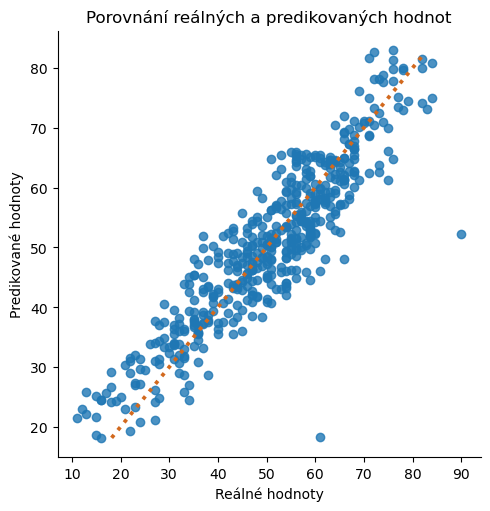

In [40]:
ax = sns.lmplot(x='Ping', y='prediction', data=df_2, fit_reg=False)

line_coordinates = np.arange(df_2['prediction'].min(), df_2['prediction'].max())
plt.plot(line_coordinates, line_coordinates, color='chocolate', linestyle='dotted', linewidth='2.7')

ax.set(title='Porovnání reálných a predikovaných hodnot', xlabel='Reálné hodnoty', ylabel='Predikované hodnoty')    

plt.show()

Vyplývá, že data jsou položena na diagonále, tudíž předpoklad je splněn. Zároveň lze detekovat dvě odlehlé hodnoty, které mohou být odstraněny. Takové hodnoty buď mohou nastat pouze velmi vyjímečně a nebo mohou vzniknout příčinou chyby měření.

#### Rezidua

Předpokladem metody <em>nejmenších čtverců</em> (anglicky <em>Least squares</em>) je, že chyby pochází z normálního rozdělení.

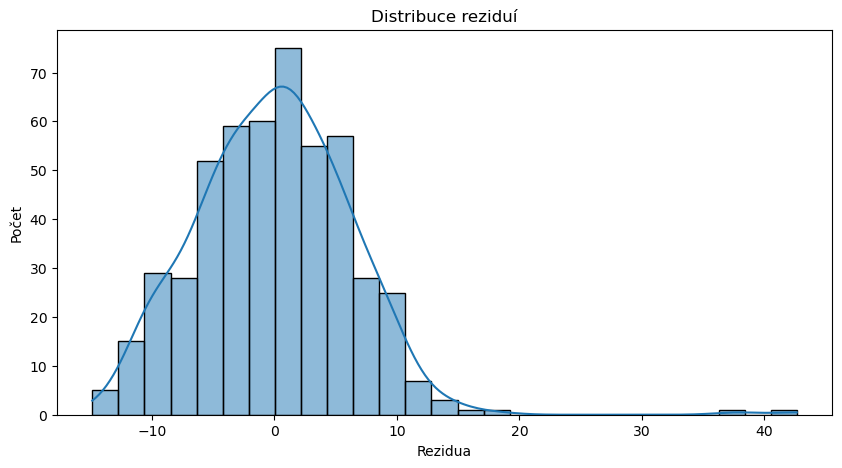

In [41]:
plt.subplots(figsize=(10, 5))

ax = sns.histplot(model_fit.resid, kde=True)
ax.set(title='Distribuce reziduí', xlabel='Rezidua', ylabel='Počet')

plt.show()

Na základě grafu by bylo možné usuzovat, že předpoklad je splněn, ovšem daná skutečnost ještě bude ověřena pomocí <em>Anderson-Darlingova testu</em>. Zároveň je možné pozorovat dříve detekované odlehlé hodnoty.

In [42]:
print(f"P-hodnota: {normal_ad(model_fit.resid)[1]}")

P-hodnota: 0.030169539168559602


Na základě Anderson-Darlingova testu lze zamítnout předpoklad normality, protože P-hodnota je menší než hodnota 0.05.

Následuje odstranění dvou odlehlých hodnot.

In [43]:
# Ošetření, pokud kód byl již jednou spuštěn, aby se data neupravovala znovu.
try:
    if DATA_IS_LOADED:
        print("Info: data are not reloaded.")
except:
    df_2 = df_2.drop(df_2[model_fit.resid > 35].index).reset_index()

DATA_IS_LOADED = True
df_2

,index,ActiveUsers,InteractingPct,ScrollingPct,Ping,MacOS,Windows,iOS,ActiveUsers_InteractingPct,ActiveUsers_MacOS,ActiveUsers_Windows,ActiveUsers_iOS,InteractingPct_MacOS,InteractingPct_Windows,InteractingPct_iOS,ActiveUsers_ActiveUsers,InteractingPct_InteractingPct,prediction
0,0,4113,0.8283,0.1717,47,0.0,0.0,1.0,3406.7979,0.0,0.0,4113.0,0.0000,0.0000,0.8283,16916769,0.686081,46.177579
1,1,7549,0.3461,0.6539,46,0.0,0.0,1.0,2612.7089,0.0,0.0,7549.0,0.0000,0.0000,0.3461,56987401,0.119785,46.972684
2,2,8855,0.2178,0.7822,55,0.0,1.0,0.0,1928.6190,0.0,8855.0,0.0,0.0000,0.2178,0.0000,78411025,0.047437,60.914651
3,3,8870,0.0794,0.9206,56,0.0,0.0,0.0,704.2780,0.0,0.0,0.0,0.0000,0.0000,0.0000,78676900,0.006304,58.953590
4,4,9559,0.7282,0.2718,76,1.0,0.0,0.0,6960.8638,9559.0,0.0,0.0,0.7282,0.0000,0.0000,91374481,0.530275,81.274092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,497,5315,0.1974,0.8026,28,0.0,0.0,1.0,1049.1810,0.0,0.0,5315.0,0.0000,0.0000,0.1974,28249225,0.038967,36.963066
496,498,1392,0.2373,0.7627,24,1.0,0.0,0.0,330.3216,1392.0,0.0,0.0,0.2373,0.0000,0.0000,1937664,0.056311,27.177504
497,499,6014,0.8112,0.1888,54,0.0,0.0,1.0,4878.5568,0.0,0.0,6014.0,0.0000,0.0000,0.8112,36168196,0.658045,49.166381
498,500,5118,0.2345,0.7655,39,0.0,0.0,0.0,1200.1710,0.0,0.0,0.0,0.0000,0.0000,0.0000,26193924,0.054990,42.268240


Poté již může být vytvořen samotný výsledný model.

In [44]:
# Definice výsledného modelu.
formula_definition = 'Ping ~ ActiveUsers + InteractingPct + Windows + ' + \
    'ActiveUsers_InteractingPct + ' + \
    'ActiveUsers_MacOS + ' + \
    'ActiveUsers_Windows + ' + \
    'ActiveUsers_iOS'
model = smf.ols(formula=formula_definition, data=df_2)
model_fit = model.fit()

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Ping   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     374.2
Date:                Sat, 16 Dec 2023   Prob (F-statistic):          1.71e-192
Time:                        18:14:45   Log-Likelihood:                -1592.3
No. Observations:                 500   AIC:                             3201.
Df Residuals:                     492   BIC:                             3234.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      8.5942      1.259      6.827      0.000       6.121      11.067
ActiveUsers                    0.0057      0.000     25.489      0.000       0.005       0.006
InteractingPct                36.6538      2.107     17.398      0.000      32.514      40.793
Windows                        8.1826      1.404      5.827      0.000       5.424      10.941
ActiveUsers_InteractingPct    -0.0035      0.000     -9.825      0.000      -0.004      -0.003
ActiveUsers_MacOS              0.0017      0.000     13.874      0.000       0.001       0.002
ActiveUsers_Windows           -0.0008      0.000     -3.513      0.000      -0.001      -0.000
ActiveUsers_iOS               -0.0010      0.000     -8.087      0.000      -0.001      -0.001
==============================================================================
Omnibus:                        4.707   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.095   Jarque-Bera (JB):                3.366
Skew:                           0.020   Prob(JB):                        0.186
Kurtosis:                       2.600   Cond. No.                     6.60e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.6e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
X = pd.DataFrame(model.exog, columns=model.exog_names)

# Získání hodnot VIF a uložení do dataframe.
vif = pd.Series([variance_inflation_factor(X.values, i) 
                 for i in range(X.shape[1])], 
                 index=X.columns)
vif_df = vif.to_frame()

# Nastavení názvu sloupce.
vif_df.columns = ['VIF']
vif_df

,VIF
Intercept,22.817977
ActiveUsers,4.598525
InteractingPct,5.601527
Windows,5.543347
ActiveUsers_InteractingPct,8.586170
ActiveUsers_MacOS,1.654880
ActiveUsers_Windows,6.455178
ActiveUsers_iOS,1.549256


In [46]:
# Zobrazení korelace prediktorů.
X.corr()

,Intercept,ActiveUsers,InteractingPct,Windows,ActiveUsers_InteractingPct,ActiveUsers_MacOS,ActiveUsers_Windows,ActiveUsers_iOS
Intercept,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ActiveUsers,NaN,1.000000,0.036544,0.000596,0.590081,0.242860,0.257546,0.188768
InteractingPct,NaN,0.036544,1.000000,-0.018190,0.752473,0.071554,0.009830,-0.051566
Windows,NaN,0.000596,-0.018190,1.000000,0.001144,-0.327407,0.874629,-0.290542
ActiveUsers_InteractingPct,NaN,0.590081,0.752473,0.001144,1.000000,0.192962,0.163177,0.052500
ActiveUsers_MacOS,NaN,0.242860,0.071554,-0.327407,0.192962,1.000000,-0.286360,-0.262490
ActiveUsers_Windows,NaN,0.257546,0.009830,0.874629,0.163177,-0.286360,1.000000,-0.254117
ActiveUsers_iOS,NaN,0.188768,-0.051566,-0.290542,0.052500,-0.262490,-0.254117,1.000000


Na základě hodnot VIF lze konstatovat, že prediktory nejsou kolineární.

Dále je vykreslen histogram po odstranění dvou odlehlých hodnot.

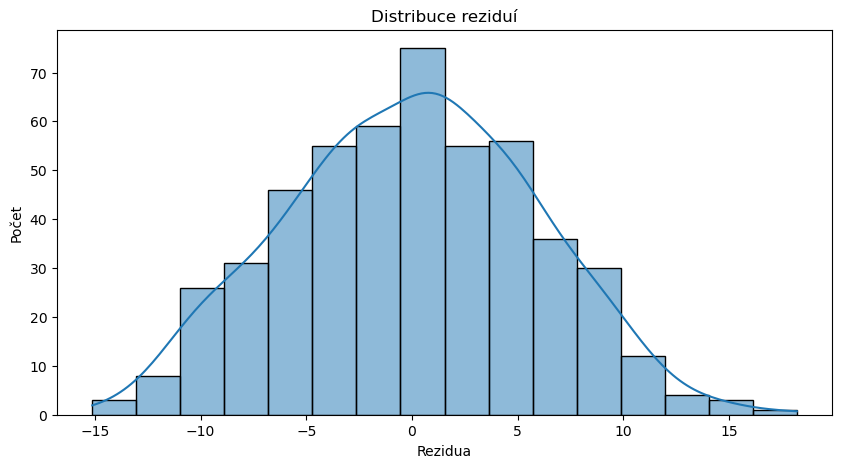

In [47]:
plt.subplots(figsize=(10, 5))

ax = sns.histplot(model_fit.resid, kde=True)
ax.set(title='Distribuce reziduí', xlabel='Rezidua', ylabel='Počet')

plt.show()

Na základě grafu histogramu lze usoudit, že nyní by již test normality mohl být splněn. Proto ještě jednou bude proveden test normality pomocí Anderson-Darlingova testu.

In [48]:
print(f"P-hodnota: {normal_ad(model_fit.resid)[1]}")

P-hodnota: 0.29993350780591116


Nyní již platí, že P-hodnota je větší než hodnota 0.05, a jedná se tedy o normální rozdělení.

Následně bude ověřena střední hodnota, která dle předpokladů musí být nulová.

In [49]:
print(f"Střední hodnota reziduí: {model_fit.resid.mean()}")

Střední hodnota reziduí: 2.725073500187136e-13


Na základě skutečnosti, že střední hodnota reziduí je velmi blízká hodnotě 0, lze považovat předpoklad za splněný.

Nakonec je vypsána ještě výsledná rovnice modelu po odstranění dvou odlehlých hodnot.

In [50]:
get_reg_eq(model_fit)

Regression equation: y = 8.594192 + 0.005670 * ActiveUsers + 36.653788 * InteractingPct + 8.182555 * Windows + -0.003483 * ActiveUsers_InteractingPct + 0.001690 * ActiveUsers_MacOS + -0.000847 * ActiveUsers_Windows + -0.001044 * ActiveUsers_iOS


#### Ověřování nezávislosti chyb

Dalším krokem, který je nutné provést, je ověření nezávislosti chyb. K tomu bude použita statistika Durbin-Watson. Pokud výsledná hodnota statistiky bude blízká hodnotě 2.0, lze považovat předpoklad za splněný.

In [51]:
print(f"Durbin-Watson: {durbin_watson(model_fit.resid)}")

Durbin-Watson: 1.913712036776804


Na základě blízkosti hodnoty 1.913712036776804 k hodnotě 2.0 lze považovat předpoklad za splněný.

#### Homoskedasticita

Jako poslední předpoklad metody nejmenších čtverců pro odhad parametrů regresní funkce bude ověřena <em>homoskedasticita</em>. Na základě té musí být rozptyl konstantní, neboli hodnoty by měly být rovnoměrně rozptýlené.

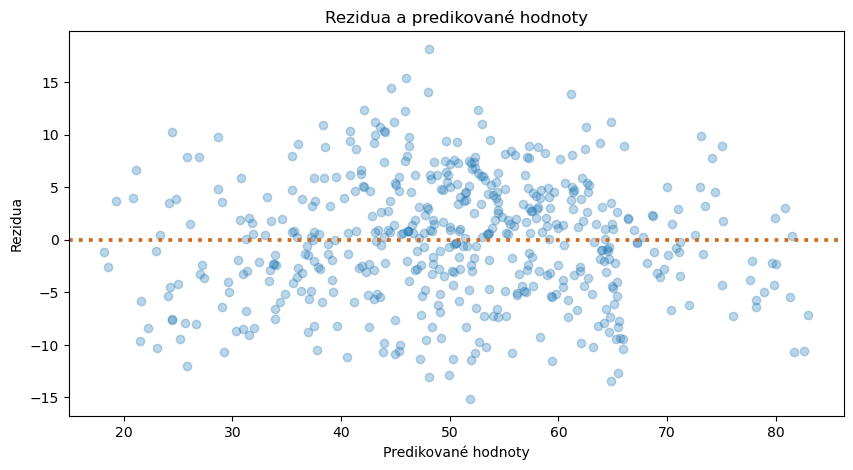

In [52]:
fig, ax = plt.subplots(figsize=(10, 5))

plt.scatter(x=df_2['prediction'], y=model_fit.resid, alpha=0.3)
plt.axhline(y=0, color='chocolate', linestyle='dotted', linewidth='2.7')
ax.set(title='Rezidua a predikované hodnoty', xlabel='Predikované hodnoty', ylabel='Rezidua')
plt.show()

Z grafu vyplývá, že i poslední předpoklad je splněn.

#### Vyobrazení výsledného modelu

Parametry výsledného modelu:
Intercept                      8.594192
ActiveUsers                    0.005670
InteractingPct                36.653788
Windows                        8.182555
ActiveUsers_InteractingPct    -0.003483
ActiveUsers_MacOS              0.001690
ActiveUsers_Windows           -0.000847
ActiveUsers_iOS               -0.001044
dtype: float64


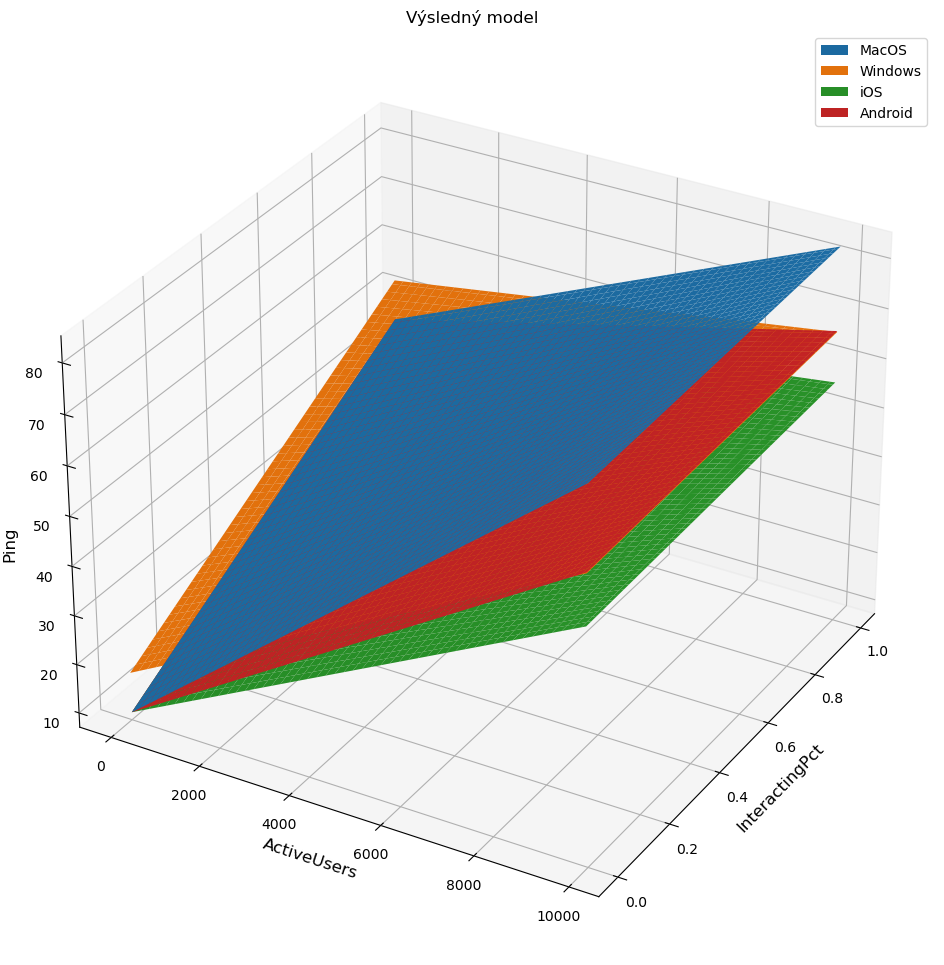

In [53]:
print('Parametry výsledného modelu:')
print(model_fit.params)

fig = plt.figure(figsize=(12,12)) 
ax = fig.add_subplot(111, projection='3d')

x = np.arange(0, 10000, 100)
y = np.arange(0.0, 1.0, 0.01)
X, Y = np.meshgrid(x, y)

zs_macos = model_fit.params['Intercept'] + \
    model_fit.params['ActiveUsers'] * X + \
    model_fit.params['ActiveUsers_MacOS'] * X + \
    model_fit.params['InteractingPct'] * Y + \
    model_fit.params['ActiveUsers_InteractingPct'] * X * Y
    # model_fit.params['ActiveUsers_ActiveUsers'] * X * X
    # model_fit.params['InteractingPct_InteractingPct'] * Y * Y
    # model_fit.params['MacOS'] + \
    # model_fit.params['InteractingPct_MacOS'] * Y + \

zs_win = model_fit.params['Intercept'] + \
    model_fit.params['Windows'] + \
    model_fit.params['ActiveUsers'] * X + \
    model_fit.params['ActiveUsers_Windows'] * X + \
    model_fit.params['InteractingPct'] * Y + \
    model_fit.params['ActiveUsers_InteractingPct'] * X * Y
    # model_fit.params['ActiveUsers_ActiveUsers'] * X * X 
    # model_fit.params['InteractingPct_Windows'] * Y + \
    # model_fit.params['InteractingPct_InteractingPct'] * Y * Y

zs_ios = model_fit.params['Intercept'] + \
    model_fit.params['ActiveUsers'] * X + \
    model_fit.params['ActiveUsers_iOS'] * X + \
    model_fit.params['InteractingPct'] * Y + \
    model_fit.params['ActiveUsers_InteractingPct'] * X * Y
    # model_fit.params['ActiveUsers_ActiveUsers'] * X * X
    # model_fit.params['iOS'] + \
    # model_fit.params['InteractingPct_iOS'] * Y + \
    # model_fit.params['InteractingPct_InteractingPct'] * Y * Y

zs_android = model_fit.params['Intercept'] + \
    model_fit.params['ActiveUsers'] * X + \
    model_fit.params['InteractingPct'] * Y + \
    model_fit.params['ActiveUsers_InteractingPct'] * X * Y
    # model_fit.params['ActiveUsers_ActiveUsers'] * X * X
    # model_fit.params['InteractingPct_InteractingPct'] * Y * Y

Z_macos = zs_macos.reshape(X.shape)
Z_win = zs_win.reshape(X.shape)
Z_ios = zs_ios.reshape(X.shape)
Z_android = zs_android.reshape(X.shape)

macos_surface = ax.plot_surface(X, Y, Z_macos, label='MacOS')
windows_surface = ax.plot_surface(X, Y, Z_win, label='Windows')
ios_surface = ax.plot_surface(X, Y, Z_ios, label='iOS')
android_surface = ax.plot_surface(X, Y, Z_android, label='Android')

# Ošetření problému s matplotlib legendou.
# Více viz:
# https://stackoverflow.com/questions/55531760/is-there-a-way-to-label-multiple-3d-surfaces-in-matplotlib
macos_surface._facecolors2d = macos_surface._facecolor3d
macos_surface._edgecolors2d = macos_surface._edgecolor3d

windows_surface._facecolors2d = windows_surface._facecolor3d
windows_surface._edgecolors2d = windows_surface._edgecolor3d

ios_surface._facecolors2d = ios_surface._facecolor3d
ios_surface._edgecolors2d = ios_surface._edgecolor3d

android_surface._facecolors2d = android_surface._facecolor3d
android_surface._edgecolors2d = android_surface._edgecolor3d

plt.title("Výsledný model")
ax.legend(loc='best')
ax.set_xlabel('ActiveUsers', fontsize=12)
ax.set_ylabel('InteractingPct', fontsize=12)
ax.zaxis._axinfo['juggled'] = (1, 2, 2) 
ax.set_zlabel('Ping', fontsize=12, rotation=90)

plt.show()

<em>2) Pomocí Vašeho výsledného modelu identifikujte, pro které nastavení parametrů má
odezva nejproblematičtější hodnotu.</em>

---

In [54]:
print(f"Nejvyšší hodnota predikce odezvy: {df_2['prediction'].max()} ms")

df_2[df_2['prediction'] == df_2['prediction'].max()]

Nejvyšší hodnota predikce odezvy: 83.00823447853553 ms


,index,ActiveUsers,InteractingPct,ScrollingPct,Ping,MacOS,Windows,iOS,ActiveUsers_InteractingPct,ActiveUsers_MacOS,ActiveUsers_Windows,ActiveUsers_iOS,InteractingPct_MacOS,InteractingPct_Windows,InteractingPct_iOS,ActiveUsers_ActiveUsers,InteractingPct_InteractingPct,prediction
227,227,9953,0.6729,0.3271,76,1.0,0.0,0.0,6697.3737,9953.0,0.0,0.0,0.6729,0.0,0.0,99062209,0.452794,83.008234


<em>3) Odhadněte hodnotu odezvy uživatele s Windows, při průměrném nastavení ostatních
parametrů a vypočtěte konfidenční interval a predikční interval pro toto nastavení.</em>

---

In [55]:
active_users_mean = df_2['ActiveUsers'].mean()
interacting_pct_mean = df_2['InteractingPct'].mean()

columns = {
    'ActiveUsers': active_users_mean,
    'InteractingPct': interacting_pct_mean,
    'Windows': 1.0,
    'ActiveUsers_InteractingPct': active_users_mean * interacting_pct_mean,
    'ActiveUsers_MacOS': active_users_mean * df_2['MacOS'],
    'ActiveUsers_Windows': active_users_mean * df_2['Windows'],
    'ActiveUsers_iOS': active_users_mean * df_2['iOS']
}

prediction = model_fit.get_prediction(pd.DataFrame(columns, index=[0]))

confidence_interval = model_fit.conf_int()
summary = prediction.summary_frame(alpha=0.05)

print(f"Bodový odhad:")
print(prediction.predicted_mean[0])
print()
print(f"Konfidenční interval:")
print(summary.mean_ci_lower[0], summary.mean_ci_upper[0])
print()
print(f"Predikční interval:")
print(summary.obs_ci_lower[0], summary.obs_ci_upper[0])

Bodový odhad:
50.76953097185954

Konfidenční interval:
47.933603916608426 53.60545802711065

Predikční interval:
38.849514338779244 62.68954760493983


<em>4) Na základě jakýchkoli vypočtených charakteristik argumentujte, zdali je Váš model
„vhodný“ pro další použití.</em>

---

Na základě výše uvedeného jsou splněny všechny předpoklady lineární regrese (metody nejmenších čtverců pro odhad parametrů regresní funkce). Po aplikaci metody zpětné eliminace a po odstranění odlehlých hodnot je P-hodnota pro všechny prediktory rovna hodnotě 0.

Také hodnoty <em>R-squared</em> a <em>Adj. R-squared</em>, tedy koeficient determinace a adjustovaný koeficient determinace, dosahují slušných hodnot, a to ```0.842``` a ```0.840```. Jelikož jsou tyto hodnoty blíže k hodnotě 1 (daná statistika může nabývat hodnot v rozsahu 0 až 1), vyplývá, že model více vystihuje data, která byla vstupem modelu. Jelikož se adjustovaný koeficient determinace velmi neliší od koeficientu determinace, indikuje to, že model není příliš komplexní.

Na druhou stranu je hodnota čísla podmíněnosti (<em>Cond. No.</em>) velká, přesně ```6.60e+04```, což značí, že i malá změna ve vstupech způsobí velkou změnu koeficientu (matice soustavy je špatně podmíněná a její výsledek může být numerický špatně spočitatelný).

Souhrnně lze na základě výše uvedených argumentů považovat model za vhodný pro následné použití.